## CBOW模型

与Skip-Gram模型不同的是，CBOW是通过上下文词来预测中心词，以此学习词汇的分布式表示(词向量)       
训练集数据及模型结构与Skip-Gram有所区别，其他类似

> 1.构建实验语料库

In [1]:
# 定义一个句子列表，后面会用这些句子来训练 CBOW 和 Skip-Gram 模型
sentences = ["Kage is Teacher", "Mazong is Boss", "Niuzong is Boss",
             "Xiaobing is Student", "Xiaoxue is Student",]

# 构建词汇表并打印
sentences_list = ' '.join(sentences).split()
word_list = list(set(sentences_list))
# 创建字典
# word -> index
word_to_idx = {word: index for index,word in enumerate(word_list)}
# index -> word
idx_to_word = {index: word for index,word in enumerate(word_list)}
voc_size = len(idx_to_word)
print(len(word_list))
print(word_to_idx)
print(idx_to_word)

9
{'Student': 0, 'Niuzong': 1, 'Teacher': 2, 'Boss': 3, 'Xiaoxue': 4, 'Xiaobing': 5, 'is': 6, 'Mazong': 7, 'Kage': 8}
{0: 'Student', 1: 'Niuzong', 2: 'Teacher', 3: 'Boss', 4: 'Xiaoxue', 5: 'Xiaobing', 6: 'is', 7: 'Mazong', 8: 'Kage'}


> 2.生成Skip-Gram数据

In [5]:
# 生成 Skip-Gram 训练数据
def create_cbow_dataset(sentences, window_size=2):
    data = [] # 初始化数据
    for sentence in sentences: # 遍历句子
        sentence = sentence.split()  # 将句子分割成单词列表
        for idx, word in enumerate(sentence):  # 遍历单词及其索引
            # 获取相邻的单词，将当前单词前后各 N 个单词作为相邻单词
            neighbor = sentence[max(idx - window_size, 0): idx] + sentence[idx + 1: min(idx + window_size + 1,len(sentence))] 
            data.append((neighbor, word))
    return data
# 使用函数创建 Skip-Gram 训练数据
cbow_data = create_cbow_dataset(sentences)
# 打印未编码的 Skip-Gram 数据样例（前 3 个）
print("Skip-Gram 数据样例（未编码）：", cbow_data[:-1]) # (input ,output)

Skip-Gram 数据样例（未编码）： [(['is', 'Teacher'], 'Kage'), (['Kage', 'Teacher'], 'is'), (['Kage', 'is'], 'Teacher'), (['is', 'Boss'], 'Mazong'), (['Mazong', 'Boss'], 'is'), (['Mazong', 'is'], 'Boss'), (['is', 'Boss'], 'Niuzong'), (['Niuzong', 'Boss'], 'is'), (['Niuzong', 'is'], 'Boss'), (['is', 'Student'], 'Xiaobing'), (['Xiaobing', 'Student'], 'is'), (['Xiaobing', 'is'], 'Student'), (['is', 'Student'], 'Xiaoxue'), (['Xiaoxue', 'Student'], 'is')]


> 3.对训练数据进行one-hot编码

In [7]:
import torch
def ont_hot_encoding(word, word_to_idx):
    tensor = torch.zeros(len(word_to_idx))
    tensor[word_to_idx[word]] = 1
    return tensor
word = 'Teacher'
tensor = ont_hot_encoding(word, word_to_idx)
print(tensor.shape)
print(tensor.float().unsqueeze(0).shape)
print(tensor.float().unsqueeze(0))
print(torch.tensor([word_to_idx[word]]).shape)

for context, target in cbow_data:
    X = torch.stack([ont_hot_encoding(word, word_to_idx) for word in context]).float()
    y_true = torch.tensor([word_to_idx[target]], dtype=torch.long)
    print(X)
    print(y_true)

torch.Size([9])
torch.Size([1, 9])
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0.]])
torch.Size([1])
tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.]])
tensor([8])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.]])
tensor([6])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.]])
tensor([2])
tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.]])
tensor([7])
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.]])
tensor([6])
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.]])
tensor([3])
tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.]])
tensor([1])
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.]])
tensor([6])
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0.,

> 4.定义CBOW模型结构

In [8]:
# 通过继承nn.Module类来实现CBOW类
import torch.nn as nn # 导入神经网络库
class CBOW(nn.Module):
    def __init__(self, voc_size, embedding_size):
        """
        embedding_size为词向量维度
        """
        super(CBOW, self).__init__()
        # 输入(ont-hot)到嵌入层 math:`y = xA^T + b`
        self.input_to_hidden = nn.Linear(voc_size, embedding_size, bias=False) 
        # 从嵌入层到输出层(等于词汇表大小)
        self.hidden_to_output = nn.Linear(embedding_size, voc_size, bias=False)
    
    def forward(self, X): # 前向传播 X形状为(num_context_words, voc_size)
        embedding = self.input_to_hidden(X) # (num_context_words, embedding_size)
        hidden_layer = torch.mean(embedding, dim=0)
        output = self.hidden_to_output(hidden_layer.unsqueeze(0)) # (batch_size, voc_size)
        return output

embedding_size = 2 # 词向量的维度, 设置为2是为了后面便于展示相关性, 通常为几百。其实通过t-SNE对高维数据降维可视化
# 实例化模型
cbow_model = CBOW(voc_size, embedding_size)
print("模型结构:", cbow_model)

模型结构: CBOW(
  (input_to_hidden): Linear(in_features=9, out_features=2, bias=False)
  (hidden_to_output): Linear(in_features=2, out_features=9, bias=False)
)


> 5.开始训练

Epoch: 100, Loss: 2.2139399528503416
Epoch: 200, Loss: 2.1946719169616697
Epoch: 300, Loss: 2.175682051976522
Epoch: 400, Loss: 2.1553058703740438
Epoch: 500, Loss: 2.1319034973780315
Epoch: 600, Loss: 2.1037625392278034
Epoch: 700, Loss: 2.0690809726715087
Epoch: 800, Loss: 2.026085623105367
Epoch: 900, Loss: 1.9733753204345703
Epoch: 1000, Loss: 1.9105819622675577


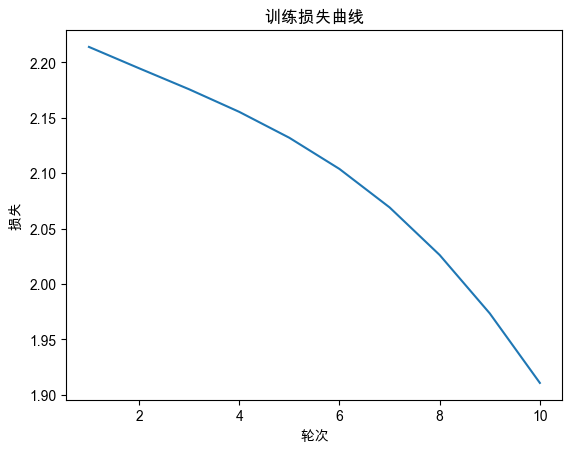

In [9]:
# 设置一些模型训练的参数
learning_rate = 0.001 # 设置学习率
epochs = 1000 # 训练轮次
criterion = nn.CrossEntropyLoss() # 定义交叉熵损失函数
import torch.optim as optim
optimizer = optim.SGD(cbow_model.parameters(), lr=learning_rate) # 梯度下降优化器
# 开始训练
loss_values = [] # 用于存储每轮的平均损失值
for epoch in range(epochs):
    loss_sum = 0
    for context, target in cbow_data:
        X = torch.stack([ont_hot_encoding(word, word_to_idx) for word in context]).float() 
        y_true = torch.tensor([word_to_idx[target]], dtype=torch.long)
        y_pred = cbow_model(X) # 得到预测值
        loss = criterion(y_pred, y_true) # 损失函数
        loss_sum += loss.item()
        optimizer.zero_grad() # 清空梯度
        loss.backward() # 误差反向传播, 主要是为了获得梯度
        optimizer.step() # 更新参数
    if (epoch+1) % 100 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss_sum/len(cbow_data)}")  
        loss_values.append(loss_sum / len(cbow_data))

# 绘制损失函数曲线
import matplotlib.pyplot as plt
# 绘制二维词向量图
plt.rcParams["font.family"]=['Arial Unicode MS'] # 用来设定字体样式
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] # 用来设定无衬线字体样式
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
plt.plot(range(1, epochs//100 + 1), loss_values) # 绘图
plt.title(' 训练损失曲线 ') # 图题
plt.xlabel(' 轮次 ') # X 轴 Label
plt.ylabel(' 损失 ') # Y 轴 Label
plt.show() # 显示图